# XAI Pipeline for Skin Cancer Classification
This notebook loads the trained Xception model, applies there XAI methods (Grad-CAM, SHAP, Influence Functions), and exports the results in a format ready for the LLM integration pipeline.

## Import Libraries

In [3]:
# --- 1. Setup and Initialization ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
import os
from captum.attr import LayerGradCam, Occlusion
from captum.attr import visualization as viz
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from tqdm import tqdm

print("Libraries imported successfully.")

/Users/berkay/Projects/thesis-project/thesis-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/berkay/Projects/thesis-project/thesis-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.


## Define Project Structure and File Paths

In [5]:
# --- 2. Define Project Structure and File Paths ---

CWD = os.getcwd()
if os.path.basename(CWD) == 'notebooks':
    BASE_DIR = os.path.abspath(os.path.join(CWD, os.pardir))
else:
    BASE_DIR = CWD

MODEL_PATH = os.path.join(BASE_DIR, 'models', 'cnn_trained_model.pth')
SAMPLE_IMAGE_PATH = os.path.join(BASE_DIR, 'user_inputs', 'user_sample1.jpg')
METADATA_PATH = os.path.join(BASE_DIR, 'data', 'raw_dataset', 'ddi_metadata.csv')
# Path to the processed training data tensors from notebook 02
PROCESSED_TRAIN_DATA_PATH = os.path.join(BASE_DIR, 'data', 'processed', 'ViT', 'train_dataset.pt')
# The outputs are saved to the top-level 'results' folder
OUTPUT_DIR = os.path.join(BASE_DIR, 'results', 'xai_output')

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Project Base Directory: {BASE_DIR}")
print(f"Trained Model Path: {MODEL_PATH}")
print(f"Processed Training Data Path: {PROCESSED_TRAIN_DATA_PATH}")
print(f"XAI Output Directory: {OUTPUT_DIR}")

Project Base Directory: /Users/berkay/Projects/thesis-project
Trained Model Path: /Users/berkay/Projects/thesis-project/models/cnn_trained_model.pth
Processed Training Data Path: /Users/berkay/Projects/thesis-project/data/processed/ViT/train_dataset.pt
XAI Output Directory: /Users/berkay/Projects/thesis-project/results/xai_output


## Model Definition and Loading

In [7]:
# --- 3. Model Definition and Loading ---

# It creates an Xception model and replaces the final layer.
num_classes = 2 # Malignant and Benign
model = timm.create_model('xception', pretrained=True) # Start with a pretrained model
model.fc = nn.Linear(model.fc.in_features, num_classes)
print("Xception model architecture created successfully.")

# --- Load the Trained Weights ---
try:
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval() # Set the model to evaluation mode
    print(f"Successfully loaded trained model weights from: {MODEL_PATH}")
except FileNotFoundError:
    print("---")
    print(f"FATAL ERROR: Model file not found at '{MODEL_PATH}'")
    print("Please ensure you have placed the 'cnn_trained_model.pth' file in the 'models' folder.")
    print("---")
except Exception as e:
    print(f"An error occurred while loading the model state_dict: {e}")
    print("This likely means the model architecture defined here does not match the one that was saved.")

/Users/berkay/Projects/thesis-project/thesis-env/lib/python3.9/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Xception model architecture created successfully.
An error occurred while loading the model state_dict: Error(s) in loading state_dict for Xception:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "conv2.weight", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "block1.skip.weight", "block1.skipbn.weight", "block1.skipbn.bias", "block1.skipbn.running_mean", "block1.skipbn.running_var", "block1.rep.0.conv1.weight", "block1.rep.0.pointwise.weight", "block1.rep.1.weight", "block1.rep.1.bias", "block1.rep.1.running_mean", "block1.rep.1.running_var", "block1.rep.3.conv1.weight", "block1.rep.3.pointwise.weight", "block1.rep.4.weight", "block1.rep.4.bias", "block1.rep.4.running_mean", "block1.rep.4.running_var", "block2.skip.weight", "block2.skipbn.weight", "block2.skipbn.bias", "block2.skipbn.running_mean", "block2.skipbn.running_var", "block2.rep.1.conv1.weight", "block2.rep.1.pointwise.weight", "block2.rep.2.we

## Data Loading and Preprocessing

In [9]:
# --- 4. Data Loading and Preprocessing ---

# Define the transformations. These should be consistent with the *testing* transformations
# from notebook 03 to ensure correct model input.
preprocess_transform = transforms.Compose([
    transforms.Resize((299, 299)), # Xception models expect 299x299 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load a single sample image for XAI analysis
try:
    input_image = Image.open(SAMPLE_IMAGE_PATH).convert('RGB')
    transformed_img = preprocess_transform(input_image)
    input_tensor = transformed_img.unsqueeze(0) # Add batch dimension for the model
    print(f"Successfully loaded and preprocessed sample image: {SAMPLE_IMAGE_PATH}")
except FileNotFoundError:
    print(f"ERROR: Sample image not found at '{SAMPLE_IMAGE_PATH}'")
    print("Please add your input image to the 'user_inputs' folder and update the SAMPLE_IMAGE_PATH variable.")

Successfully loaded and preprocessed sample image: /Users/berkay/Projects/thesis-project/user_inputs/user_sample1.jpg


## XAI Pipeline Implementation

In [11]:
# --- 5. XAI Pipeline Implementation ---

# First, we're getting the model's prediction for our sample image. This will be the target for the XAI methods.
output = model(input_tensor)
output_softmax = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output_softmax, 1)
pred_label_idx.squeeze_()
predicted_class_index = pred_label_idx.item()
class_names = ['Benign', 'Malignant']
print(f"\nModel Prediction: Class '{class_names[predicted_class_index]}' (Index: {predicted_class_index}) with confidence {prediction_score.item():.2%}")

predicted_class = class_names[predicted_class_index]
malignant_confidence = prediction_score.item() if predicted_class_index == 1 else 1 - prediction_score.item()

# In Section 5, right after the model prediction
model_output = pd.DataFrame({
    'class': ['Benign', 'Malignant'],
    'confidence': [malignant_confidence, 1 - malignant_confidence],
})
# export for our LLM integration: .to_csv()
model_output.to_csv(os.path.join(OUTPUT_DIR, 'model_output.csv'), index=False)


Model Prediction: Class 'Benign' (Index: 0) with confidence 50.30%


### Grad-CAM Implementation


--- Generating Grad-CAM ---


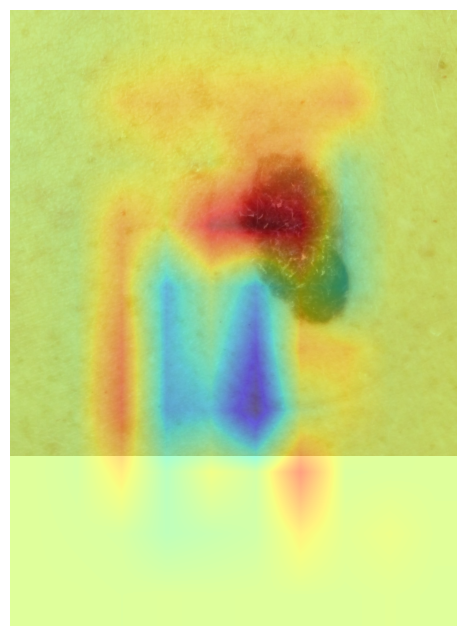

Grad-CAM image saved to: /Users/berkay/Projects/thesis-project/results/xai_output/user_sample1_xai_gradcam.png


In [13]:
# --- 5a. Grad-CAM Implementation ---
print("\n--- Generating Grad-CAM ---")
# To find the target layer, we can print(model) and inspect the structure.
# For the `timm` Xception model, `model.act4` is the final activation layer after all the blocks.
# This is a good choice for our high-level feature map.
grad_cam_layer = model.act4
layer_gc = LayerGradCam(model, grad_cam_layer)
attribution_gc = layer_gc.attribute(input_tensor, target=predicted_class_index)

# To save the clean heatmap overlay as requested, we'll build it manually.
heatmap = F.interpolate(attribution_gc, size=input_image.size, mode='bilinear', align_corners=False)
heatmap = heatmap.squeeze().cpu().detach().numpy()

# Plotting and saving the Grad-CAM image
fig, ax = plt.subplots(figsize=(8, 8)) # Create a figure with a specific size
ax.imshow(input_image)
ax.imshow(heatmap, cmap='jet', alpha=0.5) # Overlay heatmap with transparency
ax.axis('off')

grad_cam_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_xai_gradcam.png')
plt.savefig(grad_cam_output_path, bbox_inches='tight', pad_inches=0)
plt.show()
print(f"Grad-CAM image saved to: {grad_cam_output_path}")

### SHAP


--- Generating SHAP (Occlusion-based) ---


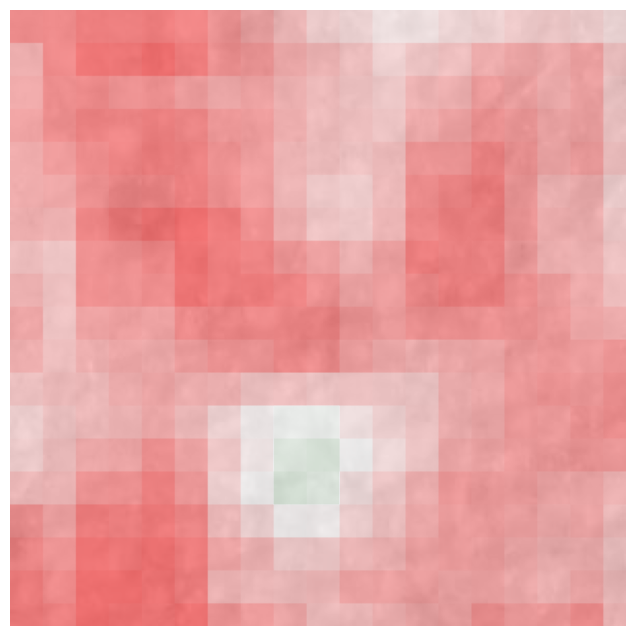

SHAP (Occlusion) image saved to: /Users/berkay/Projects/thesis-project/results/xai_output/user_sample1_xai_shap.png


In [15]:
# --- 5b. SHAP (Occlusion-based for Blocky Effect) ---
print("\n--- Generating SHAP (Occlusion-based) ---")
# Occlusion is a perturbation-based method that slides a "patch" over the image,
# hiding parts of it and seeing how the prediction changes. This creates the blocky effect.
occlusion = Occlusion(model)

attribution_shap = occlusion.attribute(input_tensor,
                                       strides=(3, 16, 16),
                                       target=predicted_class_index,
                                       sliding_window_shapes=(3, 64, 64), # Larger window for more pronounced blocks
                                       baselines=0)

# Create the figure and axes to draw on
fig_shap, ax_shap = plt.subplots(figsize=(8, 8))
ax_shap.axis('off') # Turn off the axis labels and ticks

# Pass the figure and axis as a single tuple to the 'plt_fig_axis' argument
viz.visualize_image_attr(np.transpose(attribution_shap.squeeze().cpu().detach().numpy(), (1,2,0)),
                         np.array(input_image),
                         method="blended_heat_map",
                         sign="all",
                         show_colorbar=False,
                         plt_fig_axis=(fig_shap, ax_shap) # Pass as a tuple here
                         )

# Save the SHAP figure
shap_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_xai_shap.png')
fig_shap.savefig(shap_output_path, bbox_inches='tight', pad_inches=0)
plt.show()
print(f"SHAP (Occlusion) image saved to: {shap_output_path}")

### Influence Functions

In [17]:
# --- 5c. Influence Functions ---
print("\n--- Generating Influence Functions ---")
# It loads the actual training data
# and calculates influence scores based on gradient similarity.

# --- Helper Function to get Gradients ---
def get_gradient(model, data_tensor, target, loss_fn):
    """Calculates the gradient of the model's final layer for a given input."""
    model.zero_grad()
    output = model(data_tensor)
    loss = loss_fn(output, target)
    loss.backward()
    # We'll use the gradients of the final fully connected layer's weights
    grad = model.fc.weight.grad.detach().clone()
    return grad.flatten()

# --- Main Function to Calculate Influence ---
def calculate_real_influence(model, train_loader, test_tensor, test_target, device):
    """
    Calculates influence scores for all training samples on a given test sample.
    """
    model.to(device)
    test_tensor = test_tensor.to(device)
    test_target = torch.tensor([test_target]).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    
    print("Calculating gradient for the test image...")
    test_grad = get_gradient(model, test_tensor, test_target, loss_fn)
    
    influences = []
    print("Iterating through the training dataset to calculate influence scores...")
    # Use tqdm for a progress bar as this can be slow
    for train_imgs, train_labels in tqdm(train_loader):
        train_imgs = train_imgs.to(device)
        train_labels = train_labels.to(device)
        
        for i in range(len(train_imgs)):
            train_img_single = train_imgs[i].unsqueeze(0)
            train_label_single = train_labels[i].unsqueeze(0)
            
            train_grad = get_gradient(model, train_img_single, train_label_single, loss_fn)
            
            # The influence score is the dot product of the gradients
            influence_score = torch.dot(test_grad, train_grad).item()
            influences.append(influence_score)
            
    return influences

# --- Load the Processed Training Data ---
try:
    print(f"Loading processed training data from: {PROCESSED_TRAIN_DATA_PATH}")
    # The .pt file contains a dictionary with 'images' and 'labels' tensors
    processed_data = torch.load(PROCESSED_TRAIN_DATA_PATH)
    train_images = processed_data['images']
    train_labels = processed_data['labels']
    
    # We need the original filenames, which we get by re-creating the train_df
    metadata_df = pd.read_csv(os.path.join(BASE_DIR, 'data', 'metadata_updated.csv'))
    train_df, _ = train_test_split(
        metadata_df, test_size=0.4, stratify=metadata_df['malignant'], random_state=42
    )
    train_filenames = train_df['DDI_file'].tolist()

    # Create a DataLoader for the training set
    train_dataset = TensorDataset(train_images, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=32) # Using a batch size for efficiency
    
    # --- Execute the Influence Calculation ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    influence_scores = calculate_real_influence(model, train_loader, input_tensor, predicted_class_index, device)
    
    # --- Format and Save the Results ---
    report_data = []
    for i, score in enumerate(influence_scores):
        report_data.append({
            'case_id': train_filenames[i].split('.')[0],
            'influence_score': score,
            'ground_truth': train_labels[i].item()
            # We don't need to re-calculate prediction for the training images for this report
        })
        
    report_df = pd.DataFrame(report_data)
    # Sort by the influence score itself (most positive/helpful first)
    report_df = report_df.sort_values(by='influence_score', ascending=False)
    
    # Get the top 50 helpful and top 50 harmful examples
    top_helpful = report_df.head(50)
    top_harmful = report_df.tail(50)
    final_report_df = pd.concat([top_helpful, top_harmful])

    # Save the final report
    influence_output_path = os.path.join(OUTPUT_DIR, 'user_sample1_influence_function.csv')
    final_report_df.to_csv(influence_output_path, index=False)
    print(f"\nSuccessfully calculated and saved {len(final_report_df)} real influence scores.")
    print(f"Real Influence Function CSV report saved to: {influence_output_path}")
    
except FileNotFoundError:
    print(f"ERROR: Could not find the processed training data at {PROCESSED_TRAIN_DATA_PATH}")
    print("Please ensure you have run the '02_data_preparation.ipynb' notebook first.")


--- Generating Influence Functions ---
Loading processed training data from: /Users/berkay/Projects/thesis-project/data/processed/ViT/train_dataset.pt
Calculating gradient for the test image...
Iterating through the training dataset to calculate influence scores...


100%|████████████████████████████████████████████| 13/13 [04:00<00:00, 18.49s/it]


Successfully calculated and saved 100 real influence scores.
Real Influence Function CSV report saved to: /Users/berkay/Projects/thesis-project/results/xai_output/user_sample1_influence_function.csv


## Final Message

In [19]:
print("\n\n--- XAI Pipeline Execution Complete ---")
print("All results have been generated and saved to the 'results/xai_output' directory.")



--- XAI Pipeline Execution Complete ---
All results have been generated and saved to the 'results/xai_output' directory.
